In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import chi2_contingency
import scipy.stats as stats

# classification model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

In [105]:
df = pd.read_csv(r'./../data/df_clean.csv') 
df.head()

,Unnamed: 0,customer_number,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
0,0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
3,3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
4,4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0


In [145]:
df.drop('Unnamed: 0', axis=1, inplace=True)

KeyError: "['Unnamed: 0'] not found in axis"

In [146]:
categoricals = df.select_dtypes(object)
categoricals.head()

,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home
0,Air Miles,Letter,High,No,High,No
1,Air Miles,Letter,Medium,No,Medium,Yes
2,Air Miles,Postcard,High,No,Medium,Yes
3,Air Miles,Letter,Medium,No,High,No
4,Air Miles,Letter,Medium,No,Medium,Yes


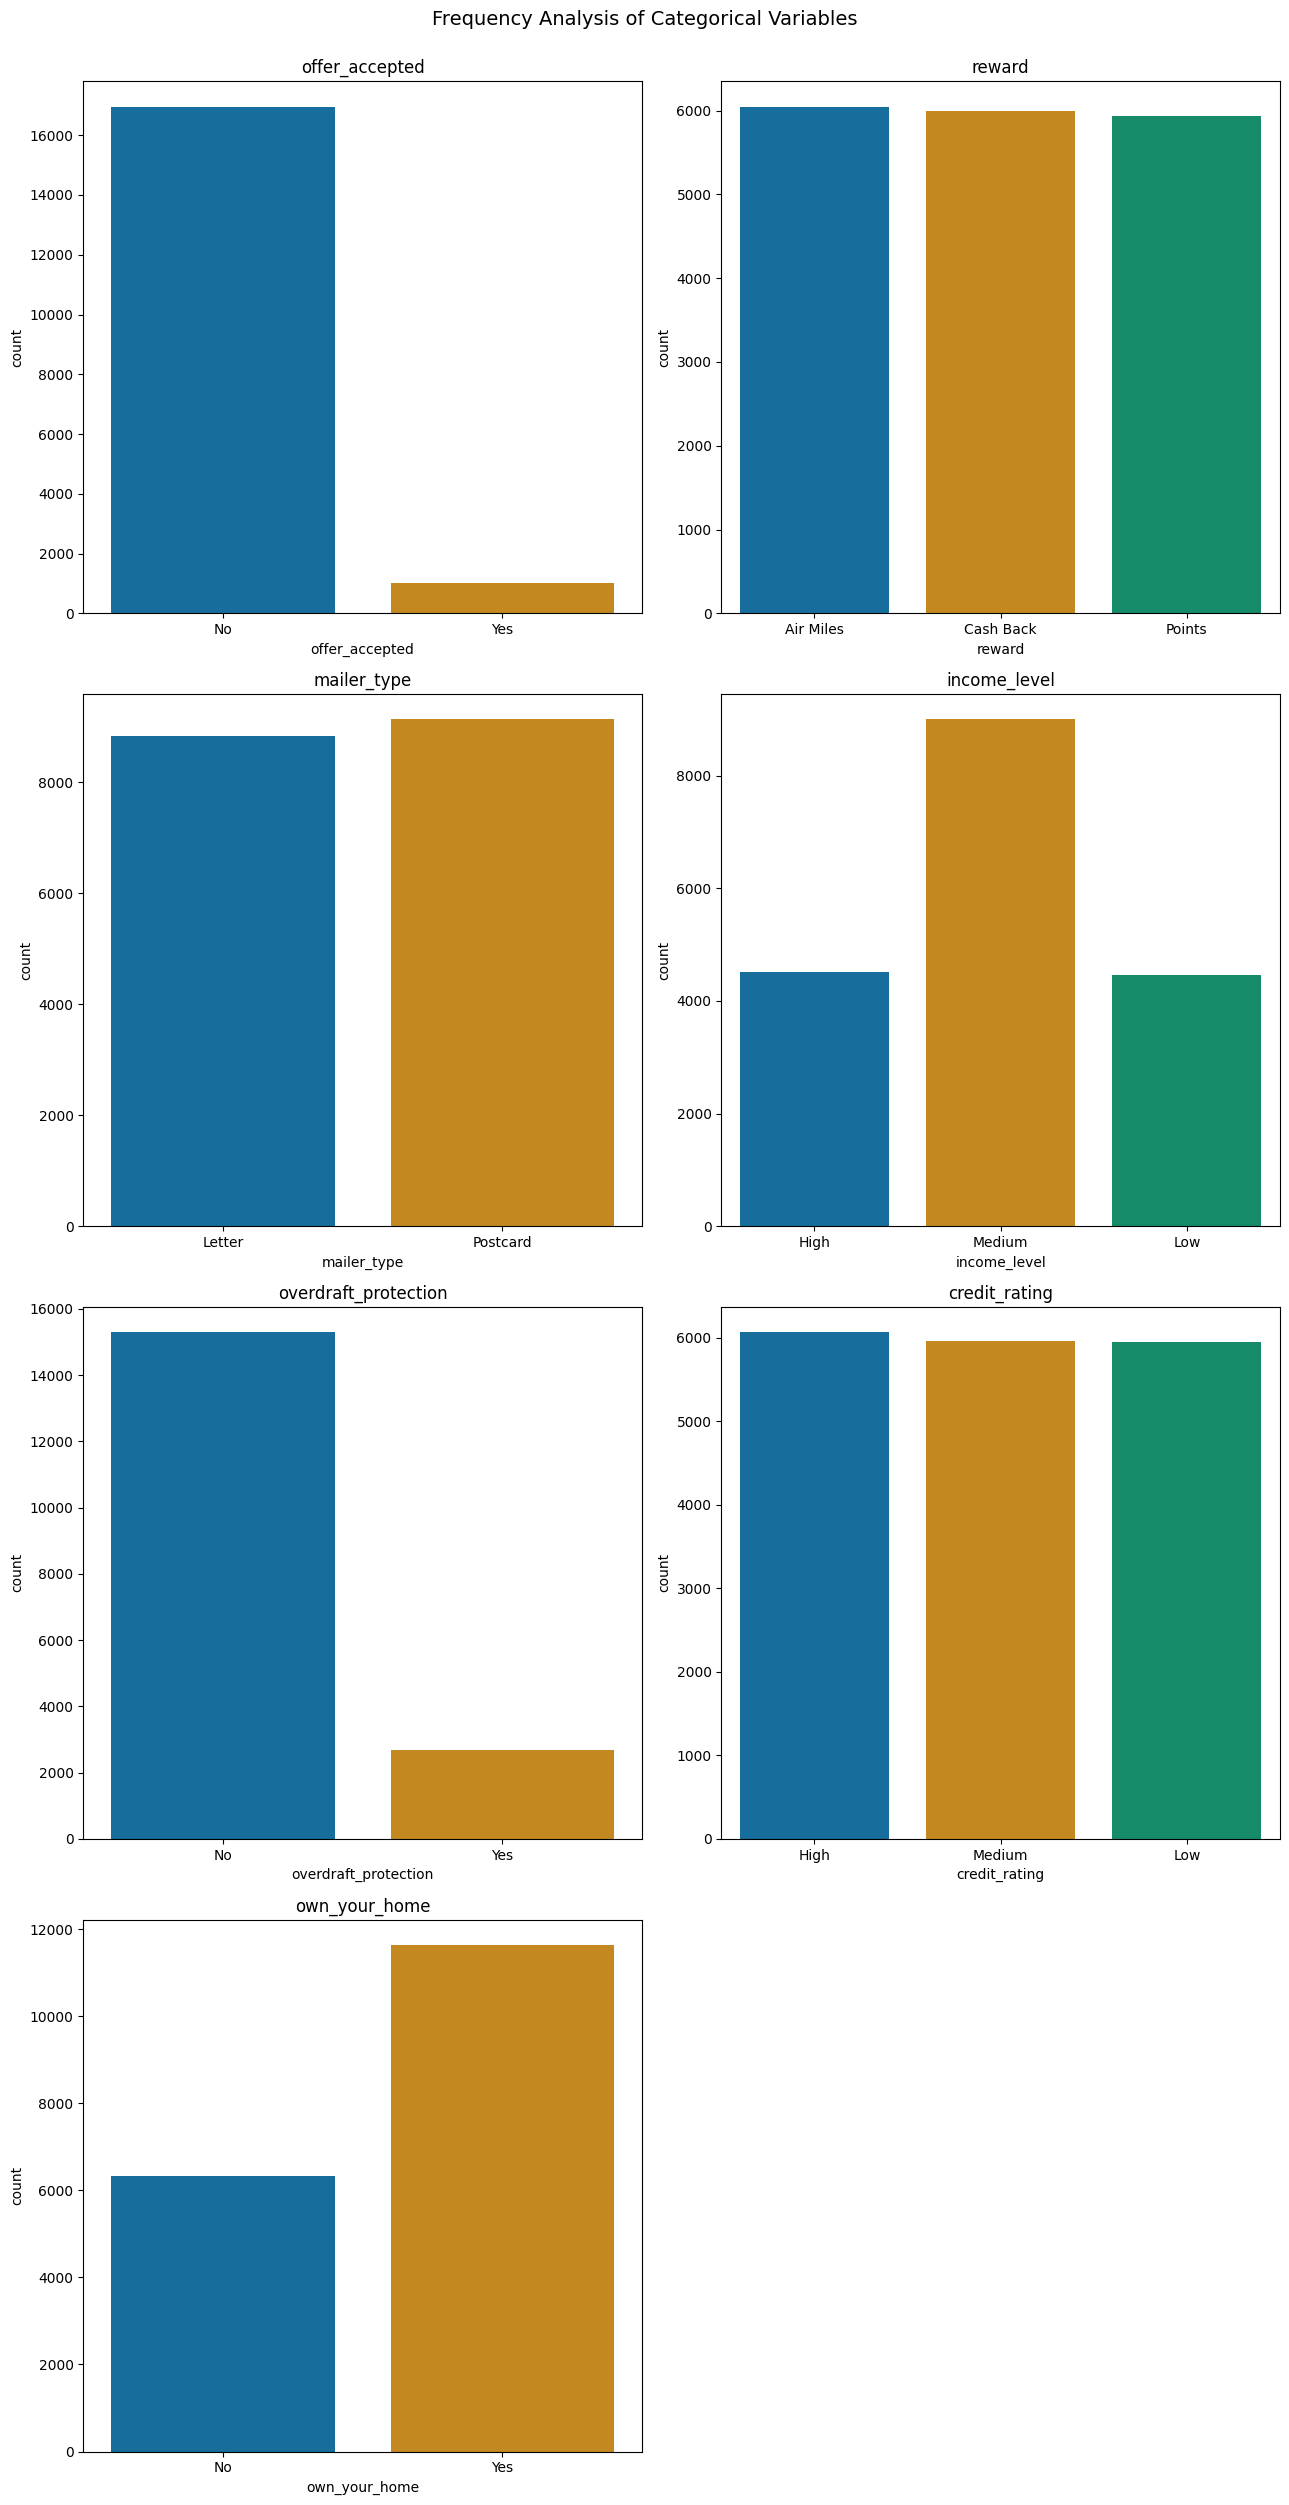

In [108]:
a = 4  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize = (13,25))
plt.suptitle("Frequency Analysis of Categorical Variables", fontsize = 14, y=1)
sns.set_palette('colorblind')

for i in categoricals:
    plt.subplot(a, b, c)
    plt.title('{}'.format(i, a, b, c))
    plt.xlabel(i)
    sns.countplot(data = categoricals, x = i)
    c = c + 1

plt.tight_layout()
plt.show()

### Homes Owned VS Number of Homes

In [109]:
homes = df[['homes_owned', 'own_your_home']]
homes.head()

,homes_owned,own_your_home
0,1,No
1,2,Yes
2,1,Yes
3,1,No
4,1,Yes


In [110]:
homes.homes_owned.unique()

array([1, 2, 3])

<Axes: ylabel='homes_owned'>

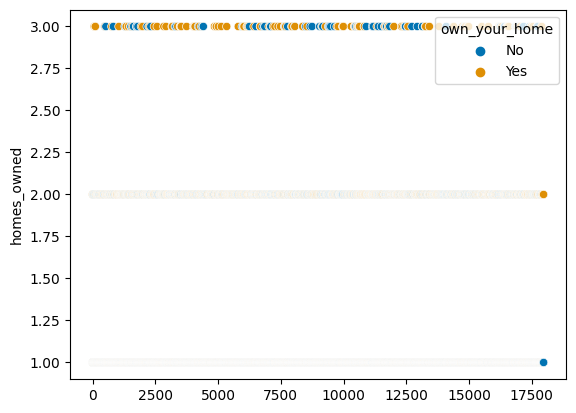

In [111]:
sns.scatterplot(data = homes, x = homes.index, y='homes_owned', hue='own_your_home')

<Axes: xlabel='own_your_home', ylabel='homes_owned'>

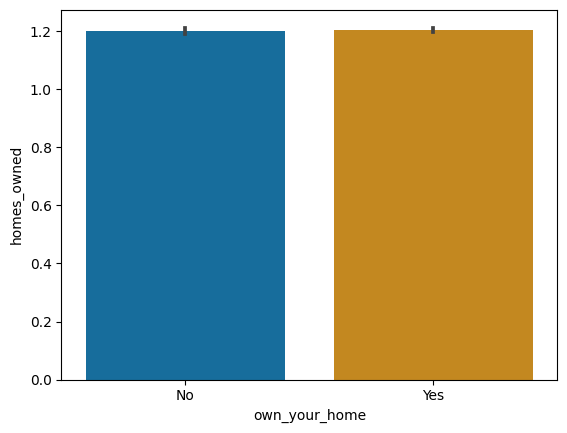

In [112]:
sns.barplot(data = homes, x='own_your_home', y = 'homes_owned')

In [113]:
from scipy.stats import f_oneway
homes_grouped = homes.groupby('own_your_home')['homes_owned'].apply(list)
homes_grouped.head()

own_your_home
No     [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, ...
Yes    [2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, ...
Name: homes_owned, dtype: object

In [114]:
anova_homes = f_oneway(*homes_grouped)
anova_homes

F_onewayResult(statistic=0.32046774616446744, pvalue=0.571333749622607)

In [115]:
homes_int = homes.copy()
homes_int.own_your_home = homes_int.own_your_home.map({'No': 0, 'Yes': 1})
homes_int.value_counts()

homes_owned  own_your_home
1            1                9368
             0                5134
2            1                2152
             0                1137
3            1                 116
             0                  69
Name: count, dtype: int64

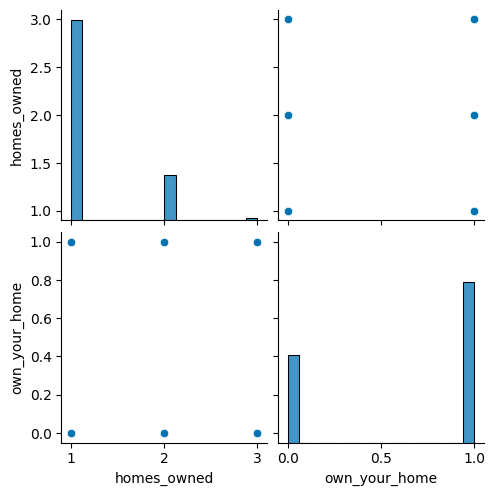

In [116]:
sns.pairplot(homes_int)

In [117]:
homes_int.corr(method='spearman')

,homes_owned,own_your_home
homes_owned,1.000000,0.005399
own_your_home,0.005399,1.000000


In [118]:
homes_int.corr(method='kendall')

,homes_owned,own_your_home
homes_owned,1.000000,0.005373
own_your_home,0.005373,1.000000


In [119]:
# Create Crosstab
homes_crosstab = pd.crosstab(homes.homes_owned, homes.own_your_home)
homes_crosstab

own_your_home,No,Yes
homes_owned,,
1,5134,9368
2,1137,2152
3,69,116


In [120]:
# Results
chi2, p_value, dof, expected_freq = chi2_contingency(homes_crosstab, correction=False)
print("The Chi2 value is: ",round(chi2,2))
print("The critical value is:", stats.chi2.ppf(1 - 0.05, df=dof).round(2))
print("The number of degrees of freedom is: ",dof)
print("The p-value is: ",p_value)
print("The expected frequencies are: ")
pd.DataFrame(expected_freq, columns=homes_crosstab.columns, index=homes_crosstab.index)

The Chi2 value is:  1.15
The critical value is: 5.99
The number of degrees of freedom is:  2
The p-value is:  0.5626754458241046
The expected frequencies are: 


own_your_home,No,Yes
homes_owned,,
1,5114.746328,9387.253672
2,1160.005563,2128.994437
3,65.248109,119.751891


- p-value > 0.05 and chi2 value is lower than the critical value so we accept the null hypothesis that there is no association between the two variables.

### Offer Accepted VS Average Balance

#### ANOVA

In [121]:
offer_bal = df[['offer_accepted', 'average_balance']]
offer_bal.head()

,offer_accepted,average_balance
0,No,1160.75
1,No,147.25
2,No,276.50
3,No,1219.00
4,No,1211.00


In [122]:
from scipy.stats import f_oneway
offer_bal_grouped = offer_bal.groupby('offer_accepted')['average_balance'].apply(list)
offer_bal_grouped.head()

offer_accepted
No     [1160.75, 147.25, 276.5, 1219.0, 1211.0, 1114....
Yes    [769.5, 851.25, 931.75, 1192.75, 1329.5, 908.5...
Name: average_balance, dtype: object

In [123]:
anova_offer_bal = f_oneway(*offer_bal_grouped)
anova_offer_bal

F_onewayResult(statistic=0.2702874265424917, pvalue=0.603145431893136)

#### Point Biserial

In [124]:
from scipy.stats import pointbiserialr

offer_bal_int = offer_bal.copy()
offer_bal_int.offer_accepted = offer_bal.offer_accepted.map({'No': 0, 'Yes': 1})

In [125]:
# pbc of first question
pbc = pointbiserialr(offer_bal_int.offer_accepted , offer_bal_int.average_balance )
print(pbc)

SignificanceResult(statistic=-0.0038778167980511296, pvalue=0.6031454318849141)


In [126]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [128]:
def fit_classifier(X, y, model_type):
    '''choose model to apply
    class_b : classification binomial logistic regression
    class_m : classification multinomial logistic regression'''
    
    #train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
    
    if model_type == 'logistic_b':
        model = LogisticRegression(random_state=1, multi_class='ovr')
    elif model_type == 'logistic_m':
        model = LogisticRegression(random_state=1, multi_class='multinomial')
    elif model_type == "knn":
        k = int(input("k="))
        w = str(input("uniform or distance?"))
        model = KNeighborsClassifier(n_neighbors=k, weights=w)
    else:
        None
    
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    return prediction


In [134]:
y.to_numpy()

array([['No'],
       ['No'],
       ['No'],
       ...,
       ['No'],
       ['No'],
       ['No']], dtype=object)

In [137]:
X1 = offer_bal.average_balance
X1.to_numpy()

array([1160.75,  147.25,  276.5 , ..., 1087.25, 1022.25, 1056.  ])

In [172]:
fit_classifier(X1.to_numpy(), y_int, 'logistic_b')

ValueError: Expected 2D array, got 1D array instead:
array=[ 813.25  787.75  894.75 ... 1022.   1197.    846.25].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
X = df = pd.read_csv(r'./../data/X.csv')
X.head()

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance,income_level,credit_rating,reward_Air Miles,reward_Cash Back,reward_Points,mailer_type_Letter,mailer_type_Postcard,overdraft_protection_No,overdraft_protection_Yes,own_your_home_No,own_your_home_Yes
0,1,2,1,4,1160.75,1669.0,877.0,1095.0,1002.0,2,2,1,0,0,1,0,1,0,1,0
1,1,2,2,5,147.25,39.0,106.0,78.0,366.0,1,1,1,0,0,1,0,1,0,0,1
2,2,2,1,2,276.50,367.0,352.0,145.0,242.0,2,1,1,0,0,0,1,1,0,0,1
3,2,1,1,4,1219.00,1578.0,1760.0,1119.0,419.0,1,2,1,0,0,1,0,1,0,1,0
4,1,2,1,6,1211.00,2140.0,1357.0,982.0,365.0,1,1,1,0,0,1,0,1,0,0,1


In [147]:
y = df = pd.read_csv(r'./../data/y.csv')
y.head()

,offer_accepted
0,No
1,No
2,No
3,No
4,No


In [168]:
y.offer_accepted.value_counts()

offer_accepted
No     16955
Yes     1021
Name: count, dtype: int64

In [165]:
y_int = pd.Series(y.offer_accepted)
y_int.unique()

array(['No', 'Yes'], dtype=object)

In [166]:
y_int = y_int.apply(lambda x: 0 if x == 'No' else 1)
y_int

0        0
1        0
2        0
3        0
4        0
        ..
17971    0
17972    0
17973    0
17974    0
17975    0
Name: offer_accepted, Length: 17976, dtype: int64

In [169]:
y_int.value_counts()

offer_accepted
0    16955
1     1021
Name: count, dtype: int64

In [167]:
y_int.unique()

array([0, 1])